In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path

### Import data

In [3]:
df_Ch001 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl"))
df_Ch009 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl"))
df_Ch020 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl"))
df_Ch022 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch022.pkl"))

### Choosing L 

In [4]:
p=10

### scaling data

In [13]:
from model_util import data_scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_input=[df_Ch001, df_Ch009, df_Ch020]
df_input_scaled=[]

LOG_SCALE= False
scaler=MinMaxScaler()

for df in df_input:
    df_input_scaled.append(data_scale(df, scaler, LOG_SCALE))

df_output_scaled, output_scaler = data_scale(df_Ch022, scaler, LOG_SCALE, output= True)

### plot intput scale data

Text(0.5, 1.0, 'Ch020')

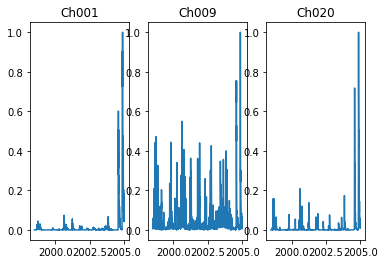

In [6]:
fig, (ax1, ax2, ax3)= plt.subplots(1,3)
ax1.plot(df_Ch022.index, df_input_scaled[0].iloc[:,p])
ax1.set_title("Ch001")

ax2.plot(df_Ch022.index, df_input_scaled[1].iloc[:,p])
ax2.set_title("Ch009")

ax3.plot(df_Ch022.index, df_input_scaled[2].iloc[:,p])
ax3.set_title("Ch020")

### plot target scale data

Text(0.5, 1.0, 'scaled output')

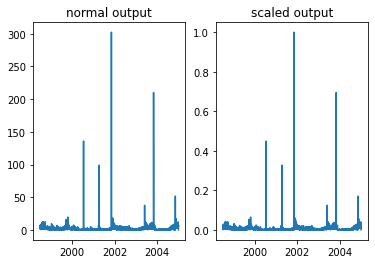

In [7]:

fig, (ax1, ax2)= plt.subplots(1,2)
ax1.plot(df_Ch022.index, df_Ch022.iloc[:,p])
ax1.set_title("normal output")
ax2.plot(df_Ch022.index, df_output_scaled.iloc[:,p])
ax2.set_title("scaled output")

### formatting data

In [19]:
data=np.dstack(df_input_scaled)[:,p,:]
target=df_output_scaled.iloc[:,p].copy().values[:,np.newaxis]

print(data.shape, target.shape)

(4722, 1, 35, 3) (4722, 1)


### split and transform data to tensor


In [9]:
#split data into test and train

size=len(df_Ch022.index)
split=int(size*0.15)

X_test=data[:split]
y_test=target[:split]

data_train=data[split:]
target_train=target[split:]

In [10]:
import torch
from sklearn.model_selection import train_test_split

In [12]:
#split data into train and val, transform all data to pytorch tensor

X_train, X_val, y_train, y_val = train_test_split(data_train, target_train, test_size=0.15, random_state=10)

X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()

X_test=torch.tensor(X_test).float()
y_test=torch.tensor(y_test).float()

train_size=y_train.shape[0]
val_size=y_val.shape[0]

In [60]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [61]:
trainset = TensorDataset(X_train, y_train)
train_loader = DataLoader(trainset, batch_size=train_size)
validationset= TensorDataset(X_val, y_val)
val_loader = DataLoader(validationset, batch_size=val_size)

### ANN model

In [62]:
class ReLUNet(nn.Module):
    def __init__(self):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(3, 40)
        self.fc2 = nn.Linear(40,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Creating Model, Optimizer and Loss

In [63]:
# creating model,and defining optimizer and loss
model = ReLUNet()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

### Training and Evaluating using Ignite

In [64]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [65]:
# defining the number of epochs
epochs = 500
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'MSE':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'loss':[]}
validation_history = {'loss':[]}
last_epoch = []

In [66]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [67]:
def score_function(engine):
    val_loss = engine.state.metrics['MSE']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [68]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['MSE']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['MSE']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)  

### model save

In [69]:
if LOG_SCALE:
    checkpointer = ModelCheckpoint(Path('./saved_models'), 'ANN_v2_log', n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)
else:
        checkpointer = ModelCheckpoint(Path('./saved_models'), 'ANN_v2_minmax', n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {str(p): model})

### Run Engine

In [70]:
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch: 1  Avg loss: 0.08
Validation Results - Epoch: 1  Avg loss: 0.08
Training Results - Epoch: 2  Avg loss: 0.07
Validation Results - Epoch: 2  Avg loss: 0.07
Training Results - Epoch: 3  Avg loss: 0.07
Validation Results - Epoch: 3  Avg loss: 0.07
Training Results - Epoch: 4  Avg loss: 0.07
Validation Results - Epoch: 4  Avg loss: 0.06
Training Results - Epoch: 5  Avg loss: 0.06
Validation Results - Epoch: 5  Avg loss: 0.06
Training Results - Epoch: 6  Avg loss: 0.06
Validation Results - Epoch: 6  Avg loss: 0.06
Training Results - Epoch: 7  Avg loss: 0.05
Validation Results - Epoch: 7  Avg loss: 0.05
Training Results - Epoch: 8  Avg loss: 0.05
Validation Results - Epoch: 8  Avg loss: 0.05
Training Results - Epoch: 9  Avg loss: 0.05
Validation Results - Epoch: 9  Avg loss: 0.05
Training Results - Epoch: 10  Avg loss: 0.04
Validation Results - Epoch: 10  Avg loss: 0.04
Training Results - Epoch: 11  Avg loss: 0.04
Validation Results - Epoch: 11  Avg loss: 0.04
Traini

State:
	iteration: 67
	epoch: 67
	epoch_length: 1
	max_epochs: 500
	output: 0.0008460290846414864
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plotting the loss and accuracy

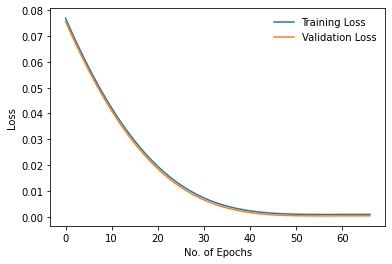

In [71]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk

In [74]:
model.load_state_dict(torch.load(Path("C:/Users/Victor/Desktop/PIR/model/saved_models/ANN_v2_minmax_10_67.pt")))
print("Model Loaded")

Model Loaded


In [75]:
from sklearn.metrics import mean_squared_error

In [77]:
model.to("cpu")

y_pred_test=model(X_test).detach().numpy()
MSE=mean_squared_error(y_test, y_pred_test)
print(MSE)

min=output_scaler.data_min_[p]
max=output_scaler.data_max_[p]
print(min, max)
y_test=(max-min)*y_test+min
y_pred_test=(max-min)*y_pred_test+min
if LOG_SCALE:
    y_pred_test=10 ** y_pred_test


0.012807962
0.0 302.4


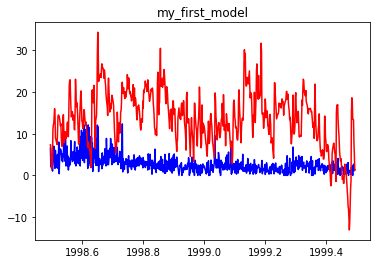

In [81]:
    plt.figure()
    plt.plot(df_Ch022.index[:split], df_Ch022.iloc[:split,p], color= "blue")
    # plt.plot(df_Ch022.index[:], y_test[:] )
    plt.plot(df_Ch022.index[:split], y_pred_test[:], color="red")
    plt.title("my_first_model")

    plt.show()